In [9]:
from __future__ import print_function
import os, cv2
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from tqdm import tqdm
ImageFile.LOAD_TRUNCATED_IMAGES = True
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

batchSize = 30

In [11]:
# Read data
trainData = datasets.ImageFolder(os.path.join(os.getcwd(), "Dataset_OpenCvDl_Hw2_Q5", "training_dataset"), transform=transform)
validData = datasets.ImageFolder(os.path.join(os.getcwd(), "Dataset_OpenCvDl_Hw2_Q5", "validation_dataset"), transform=transform)
trainLoader = torch.utils.data.DataLoader(trainData, batch_size=batchSize, shuffle=True)
validLoader = torch.utils.data.DataLoader(validData, batch_size=batchSize, shuffle=True)
print(trainData.class_to_idx)

{'Cat': 0, 'Dog': 1}


In [ ]:
# Just show model
model = torchvision.models.resnet50(pretrained=True)
nrFilters = model.fc.in_features
model.fc = nn.Linear(nrFilters, 1)
model = model.to(device)
summary(model, (3, 224, 224))

In [14]:
def saveModel(lossF="BCE"):
    path = os.path.join(os.getcwd(), "model_"+lossF+".pth")
    torch.save(model.state_dict(), path)

def validAccuracy():
    correct, total = 0, 0  # correct: 預測正確的個數, total: 總共預測個數
    
    with torch.no_grad():
        for images, labels in validLoader:
            images = images.to(device)
            labels = labels.unsqueeze(1).float()
            labels = labels.to(device)
            
            model.eval()
            outputs = model(images)
            total += labels.size(0)
            outputs = torch.sigmoid(outputs)
            predicts = np.array([0 if x <= 0.5 else 1 for x in outputs.detach().cpu().numpy().ravel()])
            correct += np.size( np.where(predicts == labels.detach().cpu().numpy().astype(np.int32).ravel()) )

    accuracy = 100 * correct / total
    return accuracy
            
def train(lossF="BCE"):
    trainAcces, validAcces = list(), list()
    epochNum = 10
    optimizer = optim.Adam(model.fc.parameters())
    if lossF == "Focal":
        lossFunc = torchvision.ops.sigmoid_focal_loss
    elif lossF == "BCE":
        lossFunc = nn.BCEWithLogitsLoss()

    print("Device: ", device)
    bestAcc = 0.0
    
    for epoch in range(epochNum):
        print("Epoch num:", epoch+1)
        lossTotal = 0.0
        correct, total = 0, 0
        
        for i, (images, labels) in enumerate(tqdm(trainLoader)):
            images = images.to(device)
            labels = labels.unsqueeze(1).float()
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            model.train()
            if lossF == "Focal":
                loss = lossFunc(outputs, labels, reduction="mean")
            else:
                loss = lossFunc(outputs, labels)
            lossTotal += loss.item()
            loss.backward()
            optimizer.step()
            
            total += labels.size(0)
            outputs = torch.sigmoid(outputs)
            predicts = np.array([0 if x <= 0.5 else 1 for x in outputs.detach().cpu().numpy().ravel()])
            correct += np.size( np.where(predicts == labels.detach().cpu().numpy().astype(np.int32).ravel()) )
#             print(outputs.detach().cpu().numpy().ravel(), predicts, labels.detach().cpu().numpy().astype(np.int32).ravel(), "correct: "+str(correct), sep="\n")#;break;

        # Compute train and validation accuracy
        trainAcc = 100 * correct / total
        validAcc = validAccuracy()
        trainAcces.append(trainAcc)
        validAcces.append(validAcc)
        lossAvg = lossTotal / (total / batchSize)
        
        print("The loss of training set is %.3f" % (lossAvg))
        print("The training accuracy is %d %%" % (trainAcc))
        print("The validation accruacy is %d %%" % (validAcc))
        print()
        
#         # save model
#         if validAcc > bestAcc:
#             saveModel(lossF)
#             bestAcc = validAcc
        saveModel(lossF)
            
    return trainAcces, validAcces

In [15]:
# Focal Loss
model = torchvision.models.resnet50(pretrained=True)

for params in model.parameters():
    params.requires_grad_ = False
nrFilters = model.fc.in_features
model.fc = nn.Linear(nrFilters, 1)

model = model.to(device)
trainAcces, validAcces = train("Focal")

Device:  cuda:0
Epoch num: 1


100%|█████████████████████████████████████████| 540/540 [01:39<00:00,  5.44it/s]


The loss of training set is 0.011
The training accuracy is 95 %
The validation accruacy is 97 %

Epoch num: 2


100%|█████████████████████████████████████████| 540/540 [01:39<00:00,  5.44it/s]


The loss of training set is 0.008
The training accuracy is 97 %
The validation accruacy is 96 %

Epoch num: 3


100%|█████████████████████████████████████████| 540/540 [01:39<00:00,  5.42it/s]


The loss of training set is 0.007
The training accuracy is 97 %
The validation accruacy is 98 %

Epoch num: 4


100%|█████████████████████████████████████████| 540/540 [01:39<00:00,  5.42it/s]


The loss of training set is 0.007
The training accuracy is 97 %
The validation accruacy is 96 %

Epoch num: 5


100%|█████████████████████████████████████████| 540/540 [01:39<00:00,  5.43it/s]


The loss of training set is 0.006
The training accuracy is 97 %
The validation accruacy is 98 %

Epoch num: 6


100%|█████████████████████████████████████████| 540/540 [01:39<00:00,  5.43it/s]


The loss of training set is 0.006
The training accuracy is 97 %
The validation accruacy is 98 %

Epoch num: 7


100%|█████████████████████████████████████████| 540/540 [01:39<00:00,  5.42it/s]


The loss of training set is 0.007
The training accuracy is 97 %
The validation accruacy is 96 %

Epoch num: 8


100%|█████████████████████████████████████████| 540/540 [01:39<00:00,  5.44it/s]


The loss of training set is 0.006
The training accuracy is 97 %
The validation accruacy is 97 %

Epoch num: 9


100%|█████████████████████████████████████████| 540/540 [01:39<00:00,  5.42it/s]


The loss of training set is 0.007
The training accuracy is 97 %
The validation accruacy is 97 %

Epoch num: 10


100%|█████████████████████████████████████████| 540/540 [01:40<00:00,  5.39it/s]


The loss of training set is 0.008
The training accuracy is 97 %
The validation accruacy is 98 %



In [16]:
# BCE Loss
model = torchvision.models.resnet50(pretrained=True)

for params in model.parameters():
    params.requires_grad_ = False
nrFilters = model.fc.in_features
model.fc = nn.Linear(nrFilters, 1)

model = model.to(device)
trainAcces, validAcces = train("BCE")

Device:  cuda:0
Epoch num: 1


100%|█████████████████████████████████████████| 540/540 [01:39<00:00,  5.42it/s]


The loss of training set is 0.102
The training accuracy is 96 %
The validation accruacy is 98 %

Epoch num: 2


100%|█████████████████████████████████████████| 540/540 [01:41<00:00,  5.31it/s]


The loss of training set is 0.061
The training accuracy is 97 %
The validation accruacy is 98 %

Epoch num: 3


100%|█████████████████████████████████████████| 540/540 [01:40<00:00,  5.39it/s]


The loss of training set is 0.057
The training accuracy is 97 %
The validation accruacy is 98 %

Epoch num: 4


100%|█████████████████████████████████████████| 540/540 [01:40<00:00,  5.38it/s]


The loss of training set is 0.055
The training accuracy is 97 %
The validation accruacy is 98 %

Epoch num: 5


100%|█████████████████████████████████████████| 540/540 [01:41<00:00,  5.34it/s]


The loss of training set is 0.047
The training accuracy is 98 %
The validation accruacy is 98 %

Epoch num: 6


100%|█████████████████████████████████████████| 540/540 [01:40<00:00,  5.36it/s]


The loss of training set is 0.049
The training accuracy is 98 %
The validation accruacy is 98 %

Epoch num: 7


100%|█████████████████████████████████████████| 540/540 [01:39<00:00,  5.41it/s]


The loss of training set is 0.048
The training accuracy is 98 %
The validation accruacy is 98 %

Epoch num: 8


100%|█████████████████████████████████████████| 540/540 [01:40<00:00,  5.39it/s]


The loss of training set is 0.048
The training accuracy is 98 %
The validation accruacy is 98 %

Epoch num: 9


100%|█████████████████████████████████████████| 540/540 [01:39<00:00,  5.42it/s]


The loss of training set is 0.050
The training accuracy is 98 %
The validation accruacy is 98 %

Epoch num: 10


100%|█████████████████████████████████████████| 540/540 [01:39<00:00,  5.40it/s]


The loss of training set is 0.048
The training accuracy is 98 %
The validation accruacy is 98 %



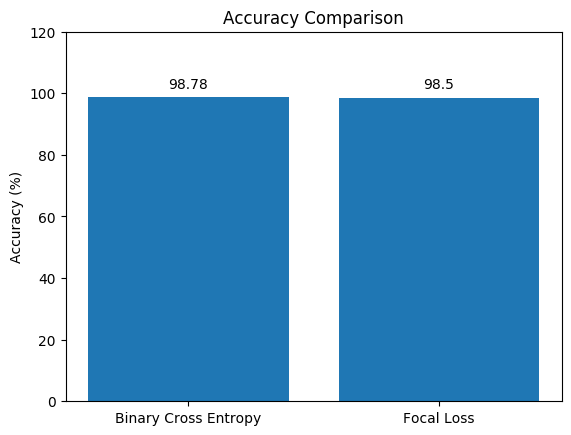

In [18]:
# transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
batchSize = 20

# Load Data
validData = datasets.ImageFolder(os.path.join(os.getcwd(), "Dataset_OpenCvDl_Hw2_Q5", "validation_dataset"), transform=transform)
validLoader = torch.utils.data.DataLoader(validData, batch_size=batchSize, shuffle=True)

# Compute accruacy
def compute(model):
    correct, total = 0, 0
    for images, labels in validLoader:
        images = images.to(device)
        labels = labels.unsqueeze(1).float()
        labels = labels.to(device)

        model.eval()
        outputs = model(images)
        total += labels.size(0)
        outputs = torch.sigmoid(outputs)
        predicts = np.array([0 if x <= 0.5 else 1 for x in outputs.detach().cpu().numpy().ravel()])
        correct += np.size( np.where(predicts == labels.detach().cpu().numpy().astype(np.int32).ravel()) )
    acc = 100 * correct / total
    return acc

# Validation Accruacy of Focal Loss
modelFocal = torchvision.models.resnet50()
fcIn = modelFocal.fc.in_features
modelFocal.fc = nn.Linear(fcIn, 1)
modelFocal.to(device)
modelFocal.load_state_dict( torch.load( os.path.join(os.getcwd(), "model_Focal.pth") ) )
accF = compute(modelFocal)

# Validation Accuracy of BCE Loss
modelBCE = torchvision.models.resnet50()
fcIn = modelBCE.fc.in_features
modelBCE.fc = nn.Linear(fcIn, 1)
modelBCE.to(device)
modelBCE.load_state_dict( torch.load( os.path.join(os.getcwd(), "model_BCE.pth") ) )
accB = compute(modelBCE)

# Plot both accuracy
path = os.path.join(os.getcwd(), "")

x = ["Binary Cross Entropy", "Focal Loss"]
y = [accB, accF]
plt.ylim(0, 120)
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison")
accImg = plt.bar(x, y)

for idx, acc in enumerate(y):
    plt.text(idx, acc+2, str(round(acc, 2)), ha="center", va="bottom")

plt.savefig("accCompare.png")
plt.show()

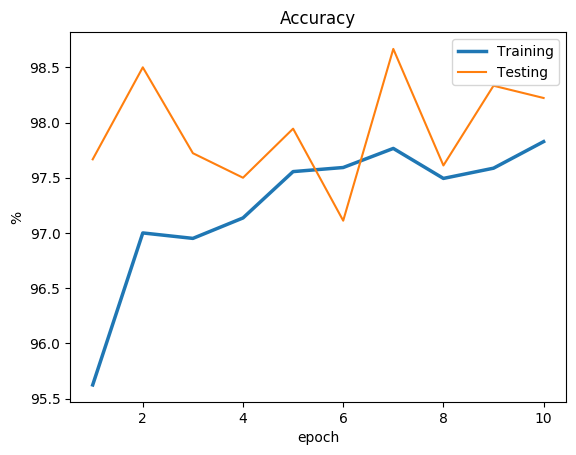

In [79]:
def plot(trainAcc, testAcc):
    # Accuracy plt
    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("%")
    numLst = list( range(1, len(trainAcc)+1) )
    plt.plot(numLst, trainAcc, label="Training", linewidth=2.5)
    plt.plot(numLst, testAcc, label="Testing")
    plt.legend()
    
    plt.savefig("Acc.png")
    plt.show()
    
plot(trainAcces, validAcces)

In [11]:
testData = datasets.ImageFolder(os.path.join(os.getcwd(), "inference_dataset"), transform=transform)
testLoader = torch.utils.data.DataLoader(testData, batch_size=5, shuffle=True)
correct, total = 0, 0

model = torchvision.models.resnet50()
fcIn = model.fc.in_features
model.fc = nn.Linear(fcIn, 1)
model.to(device)
model.load_state_dict( torch.load( os.path.join(os.getcwd(), "model_BCE_prv.pth") ) )

for images, labels in testLoader:
    print(images[0].shape)
    images = images.to(device)
    labels = labels.unsqueeze(1).float()
    labels = labels.to(device)

    model.eval()
    outputs = model(images)
    total += labels.size(0)
    print(outputs)
    outputs = torch.sigmoid(outputs)
    predicts = np.array([0 if x <= 0.5 else 1 for x in outputs.detach().cpu().numpy().ravel()])
    correct += np.size( np.where(predicts == labels.detach().cpu().numpy().astype(np.int32).ravel()) )
    print(outputs.detach().cpu().numpy().ravel(), predicts, labels.detach().cpu().numpy().astype(np.int32).ravel(), "correct: "+str(correct), sep="\n")#;break;
    

torch.Size([3, 224, 224])
tensor([[-11.4964],
        [-13.4164],
        [ 10.9067],
        [ 13.3147],
        [-12.8259]], device='cuda:0', grad_fn=<AddmmBackward0>)
[1.01665355e-05 1.49050607e-06 9.99981642e-01 9.99998331e-01
 2.69028942e-06]
[0 0 1 1 0]
[0 0 1 1 0]
correct: 5
torch.Size([3, 224, 224])
tensor([[-10.0830],
        [  4.8845],
        [-15.4755],
        [  7.8142],
        [  5.9207]], device='cuda:0', grad_fn=<AddmmBackward0>)
[4.1782681e-05 9.9249387e-01 1.9014202e-07 9.9959618e-01 9.9732375e-01]
[0 1 0 1 1]
[0 1 0 1 1]
correct: 10


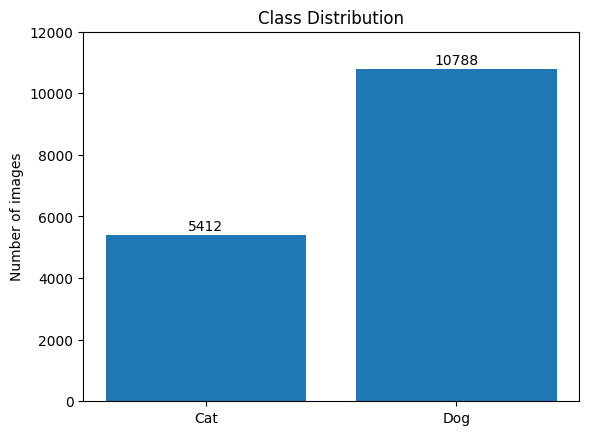

In [9]:
# Plot training dataset distrubution
path = os.path.join(os.getcwd(), "")
catLen = len( os.listdir( os.path.join(os.getcwd(), "Dataset_OpenCvDl_Hw2_Q5", "training_dataset", "Cat") ) )
dogLen = len( os.listdir( os.path.join(os.getcwd(), "Dataset_OpenCvDl_Hw2_Q5", "training_dataset", "Dog") ) )

x = ["Cat", "Dog"]
y = [catLen, dogLen]
plt.ylabel("Number of images")
plt.ylim(0, 12000)
plt.title("Class Distribution")
dtb = plt.bar(x, y)

for idx, cLen in enumerate(y):
    plt.text(idx, cLen+50, str(cLen), ha="center", va="bottom")

plt.savefig("distribution.png")
plt.show()